# Logistic Regression

Here we use numpy and self-implemented utilities to perform binary logistic regression on a toy dataset.
Negative log likelihood is used as the objective function. Ridge regression has also been implemented.

Following training, the predictions over a space are plotted and so as to be compared with ground truth.

In the first moment we do this using linear features. Afterwards, we attempt the same task with quadratic features. We will see that using quadratic fe

In [219]:
#load data
data = np.loadtxt("data.txt")

Optimal parametres:  [-0.00995111 -0.4993247   1.22822868]
Mean Negative Log Likelihood:  0.46119839372495236


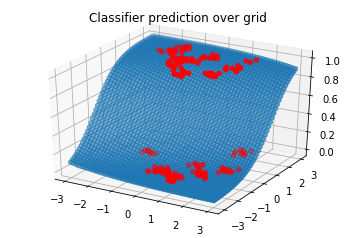

In [220]:
########################
# linear features
########################

# get rid of label column
X, y = data[:, :2], data[:, 2]
# prepend one to data matrix to help with bias training
X = prepend_one(X)
# newton iteration to train parametres
B = iterate_newton(X, y, 0, np.zeros(shape=len(X[0])), 20)
# use the sigmoid function to perform predictions
probs = sigmoid(X, B)
print('Optimal parametres: ', B)
print('Mean Negative Log Likelihood: ', mean_nll(probs, y, B, 0))

# begin visualization
X_grid = prepend_one(grid2d(-3, 3, num=50))
y_grid = sigmoid(X_grid, B)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_grid[:, 1], X_grid[:, 2], y_grid) # dont use the 1 infront
ax.scatter(X[:, 1], X[:, 2], y, color="red") # also show the real data
ax.set_title("Classifier prediction over grid")
plt.show()

Optimal parametres:  [ 1.87419295  0.59925241  3.14566435 -1.19516899 -0.79316518 -1.18641318]
Mean Negative Log Likelihood:  0.2867050424189358


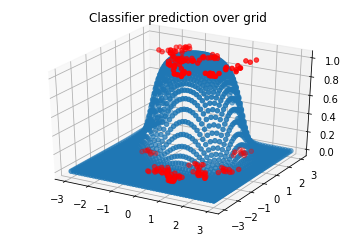

In [221]:
#######################
# quadratic features  #
#######################

# reset X and y
X, y = data[:, :2], data[:, 2]
# construct a new matrix with quadratic features
nlX = nonlinear_matrix(X, 2)
# prepend one to this matrix for bias training
nlX = prepend_one(nlX) 

X = prepend_one(X)
# train weights
B = iterate_newton(nlX, y, 0, np.zeros(shape=len(nlX[0])), 20)
probs = sigmoid(nlX, B)
print('Optimal parametres: ', B)
print('Mean Negative Log Likelihood: ', mean_nll(probs, y, B, 0))

# begin visualization
X_grid = grid2d(-3, 3, num=50)
y_grid = sigmoid(prepend_one(nonlinear_matrix(X_grid, 2)), B)
X_grid = prepend_one(X_grid)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_grid[:, 1], X_grid[:, 2], y_grid)
ax.scatter(X[:, 1], X[:, 2], y, color="red") 
ax.set_title("Classifier prediction over grid")
plt.show()


## Here we place a variety of utilities used for the task.

In [218]:
import numpy as np
import itertools
from numpy import dot
from numpy.linalg import inv, norm
from numpy.linalg import multi_dot as mdot
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d.axes3d import Axes3D
from sklearn.model_selection import KFold
import math

def prepend_one(X):
    """prepend a one vector to X."""
    return np.column_stack([np.ones(X.shape[0]), X])

def grid2d(start, end, num=50):
    """Create an 2D array where each row is a 2D coordinate.
    np.meshgrid is pretty annoying!
    """
    dom = np.linspace(start, end, num)
    X0, X1 = np.meshgrid(dom, dom)
    return np.column_stack([X0.flatten(), X1.flatten()])

def sigmoid(x, B):
    p = 1 / (1 + np.exp(-(dot(x, B))))
    return p

def mean_nll(probs, y, B, l):
    nlls = y*np.log(probs) + (1 - y)*np.log(1 - probs)
    return (-1 * np.mean(nlls) + l*norm(B[1:]))

def nll_derivative(X, probs, y, l, B):
    I = np.eye(len(B))
    I[0][0] = 0
    return dot(X.T, (probs - y)) + 2*l*dot(I, B)

def hessian(X, l, probs, B):
    I = np.eye(len(probs))
    I[0][0] = 0
    W = np.zeros(shape=(len(probs), len(probs)))
    for i, p in enumerate(probs):
        W[i][i] = p
    I = np.eye(len(B))
    I[0][0] = 0
    return mdot([X.T, W, X]) + 2*l*I

def iterate_newton(X, y, l, B, n):
    for i in range(n):
        probs = sigmoid(X, B)
        nll_der = nll_derivative(X, probs, y, l, B)
        hess = hessian(X, l, probs, B)
        B = B - dot(inv(hess), nll_der.T)
    return B

def plot_classification(probs, X, y):
    preds = []
    for prob in probs:
        if prob >= .5:
            preds.append(1)
        else:
            preds.append(0)
    print(preds)
    print(y)
    plt.subplot(212)
    ax0 = plt.subplot(2,1,1)
    ax1 = plt.subplot(2,1,2)
    colors = ['red','purple']
    ax0.scatter(X[:,1],X[:,2], c=y, cmap=ListedColormap(colors))
    ax0.set_title('data')
    ax1.scatter(X[:,1],X[:,2], c=probs, cmap=ListedColormap(colors))
    ax1.set_title('predictions')
    plt.show()

def mean_squared_error(pred, y):
    return (((y - pred) ** 2)).mean(axis=None)

def squared_error(pred, y):
    return np.sum((y - pred) ** 2)


def findsubsets(arry, n):
    as_list = arry[:, ].tolist()
    subsets = []
    for i in range(1, n + 1):
        new = list(itertools.combinations_with_replacement(as_list, i))
        subsets += new
    return subsets

def nonlinear_array(subsets):
    new_array = np.array([])
    for feature in subsets:
        to_append = 1
        for value in feature:
            to_append *= value
        new_array = np.append(new_array, [to_append], axis=0)
    return new_array

def nonlinear_matrix(matrix, n):
    initialized_matrix = False
    for row in matrix:
        subsets = findsubsets(row, n)
        new_array = nonlinear_array(subsets)
        if not initialized_matrix:
            new_matrix = np.array([new_array])
            initialized_matrix = True
        else:
            new_matrix = np.vstack([new_matrix, new_array])
    return new_matrix

def cross_validate(X, y, I, L, k):
    kf = KFold(n_splits=k)
    kf.get_n_splits(X)
    test_mean_sq_errs = np.array([])
    betas = np.zeros((1, 6))

    for train_index, test_index in kf.split(X):
        # train_index = np.random.choice(train_index, size=(10,))
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        beta_ = mdot([inv(dot(X_train.T, X_train) + L * I), X_train.T, y_train])
        betas = np.vstack([betas, beta_])

        test_predictions = np.array([])
        for x in X_test:
            test_predictions = np.hstack([test_predictions, dot(x, beta_)])
        test_mean_sq_errs = np.append(test_mean_sq_errs, [mean_squared_error(test_predictions, y_test)])

    betas = np.mean(betas[1:], axis=0)
    print(len(betas))
    train_predictions = np.array([])
    for x in X:
        train_predictions = np.hstack([train_predictions, dot(x, betas)])

    train_sq_err = squared_error(train_predictions, y)

    print('betas', betas)
    print('training error', train_sq_err)
    print('validation error', np.sum(test_mean_sq_errs) / k)
    print('std', np.std(test_mean_sq_errs))

    return betas, train_sq_err, np.sum(test_mean_sq_errs) / k, np.std(test_mean_sq_errs)